# 학업탄력성 영향요인 연구
@author: sjh

## 1. 패키지 및 데이터 로드

In [2]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
from sys import platform

import warnings
warnings.filterwarnings('ignore')

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.autolayout"] = True

# 설치된 폰트 출력
import matplotlib.font_manager as fm
font_list = [font.name for font in fm.fontManager.ttflist]
if 'darwin' in platform:
    plt.rcParams['font.family'] = 'Malgun Gothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'

# mixed effect randomforest
# !pip install pyreadstat
import merf

BASE_DIR = os.getcwd()
print('>> Current OS: ', platform)
print('>> Current WD: ', BASE_DIR)

>> Current OS:  win32
>> Current WD:  c:\Users\jhun1\Proj\Research\MixedRF


In [3]:
class Load:
    def __init__(self, stuFolder, schFolder, tchFolder, codeBook):
        self.BASE_DIR = r'C:\Users\jhun1\Dropbox\[3]Project\[혼합효과 랜덤포레스트_2022]\PISA2018'

        # stuFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, stuFolder)) if FILE[-4:] == '.sav'][0]
        # schFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, schFolder)) if FILE[-4:] == '.sav'][0]
        # tchFile = [FILE for FILE in os.listdir(os.path.join(self.BASE_DIR, tchFolder)) if FILE[-4:] == '.sav'][0]

        # self.rawStu = pd.read_spss(os.path.join(self.BASE_DIR, stuFolder, stuFile))
        # self.rawSCH = pd.read_spss(os.path.join(self.BASE_DIR, schFolder, schFile))
        # self.rawTCH = pd.read_spss(os.path.join(self.BASE_DIR, tchFolder, tchFile))
        self.cb = pd.read_excel(codeBook)

dataSet = Load(stuFolder="STU", schFolder='SCH', tchFolder='TCH', codeBook=r'C:\Users\jhun1\Dropbox\[3]Project\[혼합효과 랜덤포레스트_2022]\drive-download-20220816T053902Z-001\PISA2018_CODEBOOK (변수선택-공유).xlsx')

In [8]:
print('>> Stu data set', dataSet.rawStu.shape)
print('>> Sch data set', dataSet.rawSCH.shape)
print('>> Tch data set', dataSet.rawTCH.shape)

>> Stu data set (612004, 1119)
>> Sch data set (21903, 197)
>> Tch data set (107367, 351)


In [31]:
class Preprocessing:
    def __init__(self, stu, sch, tch):
        self.stu = stu
        self.sch = sch
        self.tch = tch
        self.dataLS = [self.stu, self.sch, self.tch]
        

    def cleaningNational(self, SouthKorea = 'Korea', US='United States'):
        nationalData = {'SK': [], 'US': []}

        for national, code in zip(nationalData.keys(), [SouthKorea, US]):
            print(f'\n>> {national}')
            for data in self.dataLS:
                # print(data.head(5))
                temp2 = data[data['CNTRYID'] == code]
            
                nationalData[national].append(temp2)
                print('>> shape: ', temp2.shape)

        self.cleaned = nationalData
        return nationalData

    def cleaningVariable(self, codeBook):
        cleanedData = {}
        for national in self.cleaned.keys():
            toSave = {'Stu': [], 'Sch': [], 'Tch': []}
            for fileName, variable in tqdm(zip(codeBook['file name'].values, codeBook['NAME'].values), desc=">> variable check"):
                if 'STU' in fileName:
                    if variable in self.cleaned[national][0].columns:
                        toSave['Stu'].append(variable)
                    else:
                        print('>> none(stu)', variable)

                elif 'SCH' in fileName:
                    if variable in self.cleaned[national][1].columns:
                        toSave['Sch'].append(variable)
                    else:
                        print('>> none(sch)', variable)

                elif 'TCH' in fileName:
                    if variable in self.cleaned[national][2].columns:
                        toSave['Tch'].append(variable)
                    else:
                        print('>> none(tch)', variable)
            
            # print('>>>> save: ', toSave)
            cleanedData[national] = [self.cleaned[national][0][toSave['Stu']],
                                    self.cleaned[national][1][toSave['Sch']],
                                    self.cleaned[national][2][toSave['Tch']],
                                    ]
        
        return cleanedData


preprocessor = Preprocessing(stu=dataSet.rawStu, sch =dataSet.rawSCH, tch=dataSet.rawTCH)
rs = preprocessor.cleaningNational()
finalRS = preprocessor.cleaningVariable(codeBook=dataSet.cb)


>> SK
>> shape:  (6650, 1119)
>> shape:  (188, 197)
>> shape:  (4068, 351)

>> US
>> shape:  (4838, 1119)
>> shape:  (164, 197)
>> shape:  (3526, 351)


>> variable check: 97it [00:00, 97099.64it/s]
>> variable check: 97it [00:00, ?it/s]


In [33]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(SK).xlsx')) as writer:
    finalRS['SK'][0].to_excel(writer, sheet_name='stu', index=False)
    finalRS['SK'][1].to_excel(writer, sheet_name='sch', index=False)
    finalRS['SK'][2].to_excel(writer, sheet_name='tch', index=False)


with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'cleanedData(US).xlsx')) as writer:
    finalRS['US'][0].to_excel(writer, sheet_name='stu', index=False)
    finalRS['US'][1].to_excel(writer, sheet_name='sch', index=False)
    finalRS['US'][2].to_excel(writer, sheet_name='tch', index=False)

In [119]:
finalRS = {'SK': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(SK).xlsx'), sheet_name='tch'),
            ],
        'US': [
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='stu'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='sch'),
            pd.read_excel(os.path.join(BASE_DIR,'data', 'cleanedData(US).xlsx'), sheet_name='tch'),
            ]}

In [75]:
# categories 에서 일단은 codebook에 있는 변수가 다 있나 확인
# categories 에서 individual & family, school 구분

# 타겟변수 계산 수행(두가지 방법으로)
# 데이터가 총 4개 (2 x 2) 나와야함
def naVariable(nationalData):
    toDrop = {}
    
    for inputDf, label in zip(nationalData, 'stu sch tch'.split()):
        print(label)
        toDrop[label] = []
        for column in inputDf.columns:
            if inputDf[column].isna().sum() > (inputDf.shape[0] * 0.8):
                print('>>> NA: ', column)
                toDrop[label].append(column)
            
            elif 'missing' in inputDf[column].values:
                print('>>> missing: ', column)
                toDrop[label].append(column)

print('\n>>> 한국')
dropSK = naVariable(finalRS['SK'])
print('\n>>> 미국')
dropUS = naVariable(finalRS['US'])


>>> 한국
stu
>>> NA:  BEINGBULLIED
sch
>>> missing:  PRIVATESCH
tch

>>> 미국
stu
>>> NA:  PA172Q06WA
>>> NA:  DISCRIM
>>> NA:  CURSUPP
>>> NA:  EMOSUPP
>>> NA:  PASCHPOL
sch
tch
>>> NA:  TCATTIMM
>>> NA:  TCMCEG
>>> NA:  GCSELF


>> 학업성취: 0.75, 사회경제문화수준: 0.25 기준으로 시험
>> 학업성취 기준:  556.953125
>> ESCS 기준:  -0.6333500000000001

>>>> 회복탄력성 학생수:  110 (2.27)%


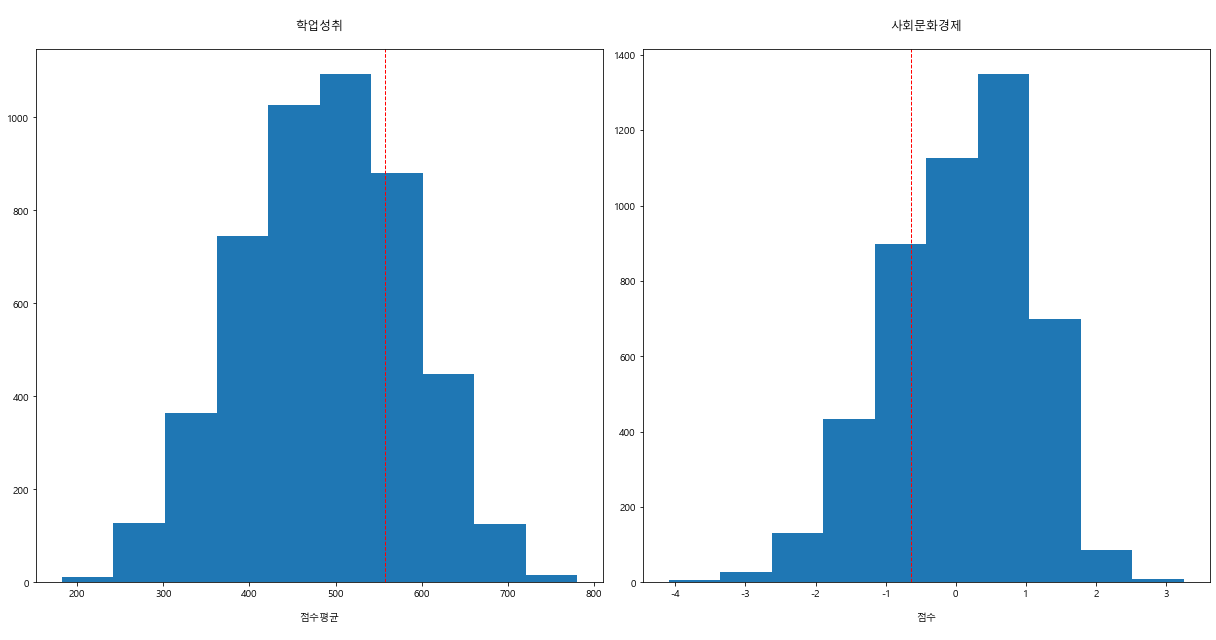

In [43]:
testBook = {
    'read/math/sci_1': 'PV1MATH PV1READ PV1SCIE'.split(),
    'read/math_1': 'PV1MATH PV1READ'.split(),
    'read/math_10': 'PV1MATH PV2MATH PV3MATH PV4MATH PV5MATH PV6MATH PV7MATH PV8MATH PV9MATH PV10MATH PV1READ PV2READ PV3READ PV4READ PV5READ PV6READ PV7READ PV8READ PV9READ PV10READ'.split(),
}

def depententVariable(inputNational, codeBook,
                    targetColumn, # 어떻게 변수를 넣어서 테스트할 것인지
                    figName, # 그림 제목
                    escsThreshold = 0.25, # 경제적 퀀타일 
                    acadThreshold = 0.75 # 학문적 퀀타일
                    ):

    temp = codeBook[codeBook['categories'] == 'resilient status']
    print(f'>> 학업성취: {acadThreshold}, 사회경제문화수준: {escsThreshold} 기준으로 시험')
    
    #!# PV1 math, PV1READ, PV1SCIE 만 사용함
    inputNational[0]['AcademicScore'] = inputNational[0].loc[:, targetColumn].mean(axis=1)

    # inputNational[0]['AcademicScore'] = academic

    acadVar = inputNational[0]['AcademicScore'].quantile(acadThreshold)
    escsVar = inputNational[0]['ESCS'].quantile(escsThreshold)
    print('>> 학업성취 기준: ', acadVar)
    print('>> ESCS 기준: ', escsVar)

    total = inputNational[0].shape[0]
    resilientCount = 0
    for idx, row in inputNational[0].iterrows():
        if row['AcademicScore'] > acadVar and row['ESCS'] < escsVar:
            resilientCount += 1
    
    print('\n>>>> 회복탄력성 학생수: ', resilientCount, f'({round(resilientCount/total*100, 2)})%')
    #!# read, math 만으로 해보기
    fig = plt.figure(figsize=(17,9))

    plt.subplot(1, 2, 1)
    plt.hist(inputNational[0]['AcademicScore'])
    plt.title('\n학업성취\n')
    plt.xlabel('\n점수평균\n')
    plt.axvline(acadVar, color='r', linewidth=1, linestyle='--')
    
    plt.subplot(1, 2, 2)
    plt.hist(inputNational[0]['ESCS'])
    plt.title('\n사회문화경제\n')
    plt.xlabel('\n점수\n')
    plt.axvline(escsVar, color='r', linewidth=1, linestyle='--')

    plt.savefig(os.path.join(BASE_DIR, 'data', f'{figName}.jpg'))
    plt.show()

    return inputNational


outputUS = depententVariable(finalRS['US'], codeBook=dataSet.cb,
                    targetColumn=testBook['read/math_1'],
                    figName ='읽수(미)1')

In [121]:
import json
import copy

with open('dummyCoding.json', encoding='utf-8') as json_file:
    dummyCodeBook = json.load(json_file)

def matchKV(codeBookDict, inputList):
    outputLS = []
    for val in inputList:
        try:
            outputLS.append(codeBookDict[val])
        except KeyError:
            outputLS.append(np.nan)
    
    return outputLS

def dummyCoding(inputNational, codeBook):
    global dummyCodeBook

    notDummyCol1 = codeBook[codeBook['categories'] == 'identifier'].index
    notDummyCol2 = codeBook[codeBook['categories'] == 'resilient status'].index
    notDummyCol3 = codeBook[codeBook['file name'] == 'should be caculated'].index
    
    toDummy = codeBook.drop(list(notDummyCol1)+list(notDummyCol2)+list(notDummyCol3), axis=0) # 더미 변환 안할 변수 행 삭제함
    # display(toDummy)
    outputNational = copy.deepcopy(inputNational)

    for idx, row in toDummy.iterrows(): # 변수별로 도는 것과 같음
        variable = row['NAME']
        # print('>>: ', variable)
        
        if ('STU' in row['file name']) and (variable in dummyCodeBook['stu']):
            outputLS = matchKV(dummyCodeBook['stu'][variable], outputNational[0][variable])
            outputNational[0][variable] = outputLS 

        # PRIVATESCH 도 마찬가지, 더미코딩할 필요 없음(코드북에도 더미코딩해두진 않음)
        # elif ('SCH' in row['file name']) and (variable in dummyCodeBook['sch']):
        #     outputLS = matchKV(dummyCodeBook['sch'][variable], outputNational[1][variable])
        #     outputNational[1][variable] = outputLS 
            
        # elif 'TCH' in row['file name']: # tch는 더미코딩할 것 없음


    return outputNational

# display(finalRS['SK'][0].head())
dummyedSK = dummyCoding(finalRS['SK'], codeBook=dataSet.cb)
dummyedUS = dummyCoding(finalRS['US'], codeBook=dataSet.cb)

dummyedRS = {'SK': dummyedSK,
            'US': dummyedUS}

In [122]:
with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'dummyed(SK).xlsx')) as writer:
    dummyedRS['SK'][0].to_excel(writer, sheet_name='stu', index=False)
    dummyedRS['SK'][1].to_excel(writer, sheet_name='sch', index=False)
    dummyedRS['SK'][2].to_excel(writer, sheet_name='tch', index=False)


with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'dummyed(US).xlsx')) as writer:
    dummyedRS['US'][0].to_excel(writer, sheet_name='stu', index=False)
    dummyedRS['US'][1].to_excel(writer, sheet_name='sch', index=False)
    dummyedRS['US'][2].to_excel(writer, sheet_name='tch', index=False)

In [125]:
def meanOrNot(TYPE, inputArr):
    # print(type(inputArr))
    if TYPE == 'NUM':
        nullCount = 0
        for val in inputArr:
            if val != val:
                nullCount += 1


        #!# nanmean, nanstd를 써야 무시됨
        return [len(inputArr)- nullCount, nullCount, np.nanmean(inputArr), np.nanstd(inputArr)]

    elif TYPE == 'CHAR':
        # print(inputArr)
        counter = {}
        nullCount = 0
        for val in inputArr:
            if (val != val) or (val == 'missing'): # nan만 본인과 본인이 다름
                nullCount += 1

            else:
                if val in counter.keys():
                    counter[val] += 1
                else:
                    counter[val] = 1
        print(counter)
        return [len(inputArr)-nullCount, nullCount, counter]
        

def descriptive(inputNational, codeBook):
    [df.reset_index(drop=True, inplace=True) for df in inputNational]

    outputCodebook = copy.deepcopy(codeBook)

    for idx, row in codeBook.iterrows():
        if (row['categories'] == 'identifier') or (row['categories'] == 'resilient status'):
            #!# should be calculated 도 계산해야함
            continue

        else:
            variableName = row['NAME']
            
            if 'STU' in row['file name']:    
                output = meanOrNot(row['TYPE'], inputNational[0][variableName].values)
                if len(output) == 4: # 누머릭인 경우
                    outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                    outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                    outputCodebook.loc[idx, '평균'] = round(output[2], 2)
                    outputCodebook.loc[idx, '표준편차'] = round(output[3], 2)

                elif len(output) == 3: # 스트링인 경우
                    outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                    outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                    outputCodebook.loc[idx, '분포'] = output[2]

            elif 'SCH' in row['file name']:
                output = meanOrNot(row['TYPE'], inputNational[1][variableName].values)
                if len(output) == 4: # 누머릭인 경우
                    outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                    outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                    outputCodebook.loc[idx, '평균'] = round(output[2], 2)
                    outputCodebook.loc[idx, '표준편차'] = round(output[3], 2)

                elif len(output) == 3: # 스트링인 경우
                    print(variableName)
                    outputCodebook.loc[idx, '빈도'] = output[0]
                    outputCodebook.loc[idx, '결측'] = output[1]
                    outputCodebook.loc[idx, '분포'] = str(output[2])
                
            elif 'TCH' in row['file name']:
                output = meanOrNot(row['TYPE'], inputNational[2][variableName].values)
                if len(output) == 4: # 누머릭인 경우
                    outputCodebook.loc[idx, '빈도'] = round(output[0], 0)
                    outputCodebook.loc[idx, '결측'] = round(output[1], 0)
                    outputCodebook.loc[idx, '평균'] = round(output[2], 2)
                    outputCodebook.loc[idx, '표준편차'] = round(output[3], 2)

                elif len(output) == 3: # 스트링인 경우
                    print(variableName)
                    outputCodebook.loc[idx, '빈도'] = output[0]
                    outputCodebook.loc[idx, '결측'] = output[1]
                    outputCodebook.loc[idx, '분포'] = str(output[2])

    return outputCodebook

descriptiveSK = descriptive(dummyedRS['SK'], codeBook = dataSet.cb)
descriptiveUS = descriptive(dummyedRS['US'], codeBook = dataSet.cb)

with pd.ExcelWriter(os.path.join(BASE_DIR, 'data', 'codebookWithDesc.xlsx')) as writer:
    descriptiveSK.to_excel(writer, sheet_name='sk', index=False)
    descriptiveUS.to_excel(writer, sheet_name='us', index=False)

{}
PRIVATESCH
{'public': 153, 'private': 11}
PRIVATESCH
